Using device: cuda
Episode 10/1000, Total Reward: -730, Epsilon: 0.9511
Episode 20/1000, Total Reward: -722, Epsilon: 0.9046
Episode 30/1000, Total Reward: -648, Epsilon: 0.8604
Episode 40/1000, Total Reward: -301, Epsilon: 0.8183
Episode 50/1000, Total Reward: -427, Epsilon: 0.7783
Episode 60/1000, Total Reward: -46, Epsilon: 0.7403
Episode 70/1000, Total Reward: -429, Epsilon: 0.7041
Episode 80/1000, Total Reward: -193, Epsilon: 0.6696
Episode 90/1000, Total Reward: -187, Epsilon: 0.6369
Episode 100/1000, Total Reward: -342, Epsilon: 0.6058
Episode 110/1000, Total Reward: -53, Epsilon: 0.5762
Episode 120/1000, Total Reward: -408, Epsilon: 0.5480
Episode 130/1000, Total Reward: -103, Epsilon: 0.5212
Episode 140/1000, Total Reward: -56, Epsilon: 0.4957
Episode 150/1000, Total Reward: -39, Epsilon: 0.4715
Episode 160/1000, Total Reward: -39, Epsilon: 0.4484
Episode 170/1000, Total Reward: -58, Epsilon: 0.4265
Episode 180/1000, Total Reward: -37, Epsilon: 0.4057
Episode 190/1000, Total R

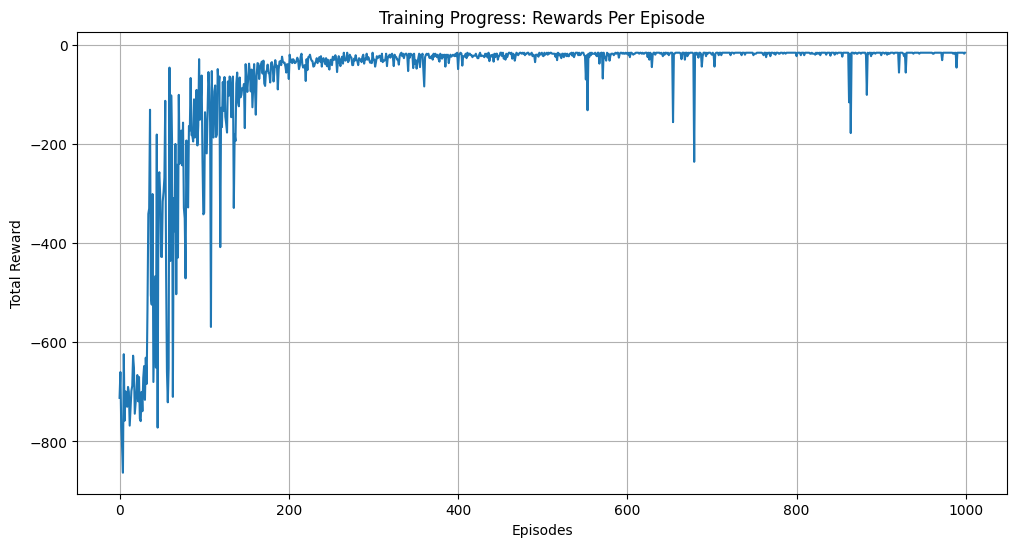

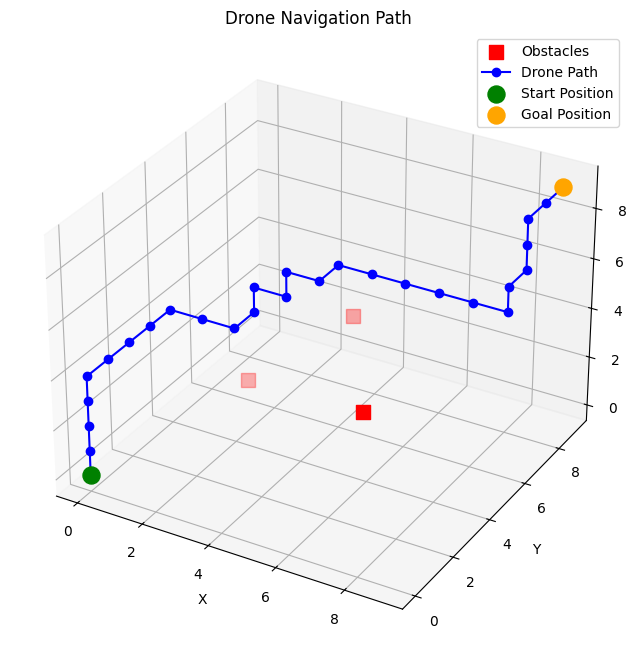

In [1]:
#!/usr/bin/env python3
"""
Robust Implementation of Autonomous Drone Navigation in a 3D Grid World using DQN with GPU support
Author: Anwar Shamim
Date: 2025-02-10

This script creates a custom Gym environment for a drone navigating a 3D grid
world with obstacles, trains a DQN agent with experience replay and target network,
and then visualizes the training rewards and the learned navigation trajectory.
"""

import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Set random seeds for reproducibility

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Define the device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Environment: DroneNavigationEnv

class DroneNavigationEnv(gym.Env):
    def __init__(self, grid_size=10):
        """
        Initialize a 3D grid world for drone navigation.

        Args:
            grid_size (int): The size of each grid dimension.
        """
        super(DroneNavigationEnv, self).__init__()
        self.grid_size = grid_size

        # the goal (farthest corner)
        self.goal_position = (grid_size - 1, grid_size - 1, grid_size - 1)
        # list of obstacles (these can be modified as needed)
        self.obstacles = [(3, 3, 3), (5, 5, 5), (7, 2, 4)]
        self.start_position = (0, 0, 0)
        self.state = np.array(self.start_position)

        # The drone can move in 6 discrete directions (x, y, z)
        self.action_space = spaces.Discrete(6)
        # The observation is simply the (x, y, z) position on the grid
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(3,), dtype=np.int32)

    def step(self, action):
        """
        Execute one time step within the environment.

        Args:
            action (int): The action chosen by the agent.

        Returns:
            state (np.array): The new state after the action.
            reward (float): The reward received.
            done (bool): Whether the episode has ended.
            info (dict): Additional information.
        """
        # 6 possible moves: right, left, up, down, forward, backward
        moves = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        new_position = self.state + np.array(moves[action])

        # if new position is out of bounds
        if np.any(new_position < 0) or np.any(new_position >= self.grid_size):
            reward = -5  # Penalty for going out of bounds
            done = False
        # if new position collides with an obstacle
        elif tuple(new_position) in self.obstacles:
            reward = -20  # Penalty for hitting an obstacle
            done = False
        # if new position is the goal
        elif tuple(new_position) == self.goal_position:
            reward = 10  # Reward for reaching the goal
            done = True
            self.state = new_position  # Updating  state to goal position
        else:
            reward = -1  # Small step penalty to encourage faster goal reach
            self.state = new_position
            done = False

        # Returning a copy of state to avoid external modifications
        return self.state.copy(), reward, done, {}

    def reset(self):
        """
        Reset the environment to the initial state.

        Returns:
            state (np.array): The starting state.
        """
        self.state = np.array(self.start_position)
        return self.state.copy()

    def render(self, mode='human'):
        """
        Render the current state of the environment.
        """
        print("Drone Position:", self.state)

# Deep Q-Network (DQN)

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        """
        Initialize the neural network.

        Args:
            state_size (int): Dimensionality of state (here, 3).
            action_size (int): Number of possible actions.
        """
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer for Experience Replay

class ReplayBuffer:
    def __init__(self, capacity):
        """
        Initialize the replay buffer.

        Args:
            capacity (int): Maximum number of experiences to store.
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Store an experience in the buffer.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a batch of experiences.
        """
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Training Function

def train_dqn(env, num_episodes=500, batch_size=32, gamma=0.99,
              epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995,
              target_update=10, device=None):
    """
    Train the DQN agent in the given environment.

    Args:
        env (gym.Env): The drone navigation environment.
        num_episodes (int): Total number of training episodes.
        batch_size (int): Batch size for experience replay.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_min (float): Minimum exploration rate.
        epsilon_decay (float): Multiplicative decay for epsilon.
        target_update (int): Frequency (in episodes) to update the target network.
        device (torch.device): The device to run the computations on.

    Returns:
        policy_net (DQN): The trained DQN model.
        rewards_per_episode (list): Total reward per episode.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initializing the policy network and target network, and move them to the device
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer(10000)

    epsilon = epsilon_start
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        total_reward = 0

        # Limiting each episode to a maximum number of steps (e.g., 500)
        for step in range(500):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)

            # Storing the experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state_tensor, done)
            state = next_state_tensor
            total_reward += reward

            # Performing experience replay if enough samples are available
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                states = torch.stack(states).to(device)
                actions = torch.tensor(actions, device=device)
                rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states = torch.stack(next_states).to(device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device)

                # Computing current Q values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

                # Computing target Q values using the target network
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                q_targets = rewards + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, q_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        # Decay epsilon (exploration)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

        # Updating the target network periodically for more stable training
        if (episode + 1) % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return policy_net, rewards_per_episode


# Testing Function: Generatied  a Trajectory

def test_dqn(env, policy_net, max_steps=100, device=None):
    """
    Run the trained policy in the environment to generate a trajectory.

    Args:
        env (gym.Env): The drone navigation environment.
        policy_net (DQN): The trained policy network.
        max_steps (int): Maximum steps to run in the episode.
        device (torch.device): The device for computations.

    Returns:
        trajectory (list): A list of states representing the path taken.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state = env.reset()
    trajectory = [state.copy()]
    state = torch.tensor(state, dtype=torch.float32, device=device)

    for step in range(max_steps):
        with torch.no_grad():
            q_values = policy_net(state)
        action = torch.argmax(q_values).item()
        next_state, reward, done, _ = env.step(action)
        trajectory.append(next_state.copy())
        state = torch.tensor(next_state, dtype=torch.float32, device=device)
        if done:
            break

    return trajectory

# Main Script
if __name__ == "__main__":
    # Creating the environment
    env = DroneNavigationEnv(grid_size=10)

    # Training of  the DQN agent (using the specified device)
    num_episodes = 1000
    policy_net, rewards_per_episode = train_dqn(env, num_episodes=num_episodes, device=device)

    # Visualization of  Training Progress

    plt.figure(figsize=(12, 6))
    plt.plot(rewards_per_episode)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Training Progress: Rewards Per Episode")
    plt.grid(True)
    plt.show()

    # Testing the trained agent and visualizing the trajectory

    trajectory = test_dqn(env, policy_net, device=device)
    trajectory = np.array(trajectory)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Ploting obstacles
    if len(env.obstacles) > 0:
        obstacles_np = np.array(env.obstacles)
        ax.scatter(obstacles_np[:, 0], obstacles_np[:, 1], obstacles_np[:, 2],
                   c='red', marker='s', s=100, label="Obstacles")

    # Ploting the drone's trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
            marker='o', color='blue', label="Drone Path")

    # Marking the start and goal positions
    ax.scatter(0, 0, 0, color="green", s=150, label="Start Position")
    ax.scatter(env.grid_size - 1, env.grid_size - 1, env.grid_size - 1,
               color="orange", s=150, label="Goal Position")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Drone Navigation Path")
    ax.legend()
    plt.show()
